<a href="https://colab.research.google.com/github/vacquaviva/Flatiron_MCMC/blob/master/TrainingRFs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import h5py

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 100)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [0]:
import time

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


Useful ref:

http://docs.h5py.org/en/stable/quick.html

In [0]:
prefixes = ['bc03_','fsps_','fsps_neb_','bpass_','bpass_sin_']

dusts = ['int_','dustA_', 'dustB_', 'dustC_']

listofspec = [p+d+'spec' for p in prefixes for d in dusts]

In [0]:
# Thanks to this kind soul
# https://stackoverflow.com/questions/51548551/reading-nested-h5-group-into-numpy-array

def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    for path, _ in h5py_dataset_iterator(hdf_file):
        yield path

In [0]:
with h5py.File('My Drive/full_histories_illustris.h5', 'r') as f:
    for dset in traverse_datasets(f):
        print('Path:', dset)
        print('Shape:', f[dset].shape)
        print('Data type:', f[dset].dtype)

In [0]:
#Read in data, SFHs, stellar mass

spectra = {}

with h5py.File('My Drive/full_histories_illustris.h5','r') as f:
    spectra = {'bc03_int_spec': f['Spectra/bc03 Intrinsic/spectrum'][:], #6473 gals, 4601 wavelengths
    'bc03_dustA_spec' : f['Spectra/bc03 Dust_A/spectrum'][:], 
    'bc03_dustB_spec' : f['Spectra/bc03 Dust_B/spectrum'][:],
    'bc03_dustC_spec' : f['Spectra/bc03 Dust_C/spectrum'][:],
    'fsps_int_spec' : f['Spectra/fsps Intrinsic/spectrum'][:],
    'fsps_dustA_spec' : f['Spectra/fsps Dust_A/spectrum'][:],
    'fsps_dustB_spec' : f['Spectra/fsps Dust_B/spectrum'][:],
    'fsps_dustC_spec' : f['Spectra/fsps Dust_C/spectrum'][:],
    'fsps_neb_int_spec' : f['Spectra/fsps Intrinsic/spectrum'][:],
    'fsps_neb_dustA_spec' : f['Spectra/fsps_neb Dust_A/spectrum'][:],
    'fsps_neb_dustB_spec' : f['Spectra/fsps_neb Dust_B/spectrum'][:],
    'fsps_neb_dustC_spec' : f['Spectra/fsps_neb Dust_C/spectrum'][:],
    'bpass_int_spec' : f['Spectra/bpass Intrinsic/spectrum'][:],
    'bpass_dustA_spec' : f['Spectra/bpass Dust_A/spectrum'][:],
    'bpass_dustB_spec' : f['Spectra/bpass Dust_B/spectrum'][:],
    'bpass_dustC_spec' : f['Spectra/bpass Dust_C/spectrum'][:],
    'bpass_sin_int_spec' : f['Spectra/bpass_sin Intrinsic/spectrum'][:],
    'bpass_sin_dustA_spec' : f['Spectra/bpass_sin Dust_A/spectrum'][:],
    'bpass_sin_dustB_spec' : f['Spectra/bpass_sin Dust_B/spectrum'][:],
    'bpass_sin_dustC_spec' : f['Spectra/bpass_sin Dust_C/spectrum'][:]}
    
    wl = f['Spectra/bc03 Dust_A/wavelength'][:]

    SFHs = f['SFH/log_8'][:]

    SMass = f['/Subhalos/Stellar Mass'][:]

    binlimits = f['/bins/log_8/binLimits'][:] 


In [0]:
ref_spec = spectra['fsps_dustB_spec']

Let's log those spectra

In [0]:
X = np.log10(ref_spec)

In [0]:
X.shape

(6473, 4601)

In [0]:
np.random.seed(10)
sel = np.random.choice(X.shape[0], 650) #make it smaller; technically should re-run optimization with seed fixed

In [0]:
model = RandomForestRegressor()

In [0]:
cv = KFold(shuffle = True, n_splits=3)

In [0]:
#All the features

#beg = time.time()
#scores = cross_val_score(model, X[sel,:], SFHs[sel,:], cv = cv, verbose = 1)
#end = time.time()
#print('It took me', end-beg, 'seconds to do this!')
#print(scores, scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.mak

It took me 259.3950970172882 seconds to do this!


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.3min finished


In [0]:
scores #r2 score with all features

array([0.88364537, 0.81579458, 0.72487614])

Unsupervised feature selection (one every two)

In [0]:
#Don't run

ypred = cross_val_predict(model, X[sel,::2], SFHs[sel,:], cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   47.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.3min finished


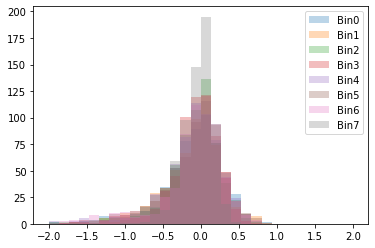

In [0]:
#Don't run

#distribution of residuals

for i in range(SFHs.shape[1]):
#  plt.figure()
  plt.hist((SFHs[sel,i] - ypred[:,i])/(SFHs[sel,i]+0.01), bins = 30, alpha = 0.3, range = [-2,2], label = 'Bin'+str(i))
plt.legend()

In [0]:
def smape(true,pred):
  return np.sum(np.abs(true-pred))/np.sum(true+pred)

In [0]:
def multioutputsmape(targets, pred):
  return np.mean(np.array([2 * smape(targets[i,:],pred[i,:]) for i in range(targets.shape[0])]))

In [0]:
smape_scorer = make_scorer(multioutputsmape, greater_is_better = False)

In [0]:
targets = SFHs[sel,:]

In [0]:
#Do not run; simple CV with every other feature and smape scorer below

#{'fit_time': array([41.71309137, 42.79233432, 41.62490797]),
# 'score_time': array([0.01293659, 0.01351094, 0.01302695]),
# 'test_score': array([-0.22774546, -0.23144261, -0.2346226 ]),
# 'train_score': array([-0.08610893, -0.08807034, -0.08678541])}

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, scoring = smape_scorer, return_train_score=True);

In [0]:
cv_results

{'fit_time': array([41.71309137, 42.79233432, 41.62490797]),
 'score_time': array([0.01293659, 0.01351094, 0.01302695]),
 'test_score': array([-0.22774546, -0.23144261, -0.2346226 ]),
 'train_score': array([-0.08610893, -0.08807034, -0.08678541])}

Optimization, based on previous runs with other scorers. Problem is high variance

---

N_est = 200, tried sqrt features which wasn't good, can try with some fractions

In [0]:
parameters = {'max_depth':[20,40], \
              'max_features': [0.25,0.5,1.0], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 3, n_jobs = 4)
model.fit(X[sel,::2], targets)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 11.9min
[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed: 19.7min finished


Best params, best score: -0.2226 {'max_depth': 40, 'max_features': 0.5, 'n_estimators': 100}


In [0]:
res = pd.DataFrame(model.cv_results_)
res[['mean_train_score','mean_test_score','std_test_score','params','mean_fit_time']].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

,mean_train_score,mean_test_score,std_test_score,params,mean_fit_time
8,-0.084193,-0.222640,0.005105,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 100}",73.701877
9,-0.083530,-0.222999,0.004353,"{'max_depth': 40, 'max_features': 0.5, 'n_estimators': 200}",147.693908
1,-0.083451,-0.223163,0.005397,"{'max_depth': 20, 'max_features': 0.25, 'n_estimators': 200}",75.390342
3,-0.083550,-0.223483,0.003220,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 200}",156.666015
7,-0.083772,-0.223762,0.003972,"{'max_depth': 40, 'max_features': 0.25, 'n_estimators': 200}",74.566892
6,-0.084240,-0.223974,0.004448,"{'max_depth': 40, 'max_features': 0.25, 'n_estimators': 100}",37.815597
5,-0.083248,-0.224185,0.004105,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 200}",294.384429
11,-0.083739,-0.224732,0.004749,"{'max_depth': 40, 'max_features': 1.0, 'n_estimators': 200}",225.702444
2,-0.084624,-0.224987,0.002861,"{'max_depth': 20, 'max_features': 0.5, 'n_estimators': 100}",76.434437
4,-0.084077,-0.225113,0.005023,"{'max_depth': 20, 'max_features': 1.0, 'n_estimators': 100}",151.228841


Results show that improvement is minimal, barely significant. We can use n_features = 0.5 and n_est = 100 to be on the safe side (should confirm through nested CV)

Shall we try GBMs and see if we can work on bias?

In [0]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
# now you can import normally from ensemble
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor


In [0]:
model_B = MultiOutputRegressor(GradientBoostingRegressor()) #Did not work, too much RAM
#model_B = GradientBoostingRegressor()
cv_results = cross_validate(model_B, X[sel,::2], targets,  cv = cv, scoring = smape_scorer, return_train_score=True);

In [0]:
cv_results

{'fit_time': array([171.49835491, 177.16797352, 175.59178376]),
 'score_time': array([0.01924682, 0.02004647, 0.02006698]),
 'test_score': array([-0.23018453, -0.22122639, -0.2529532 ]),
 'train_score': array([-0.11661452, -0.11385335, -0.11041621])}

I would say no so won't pursue it further for now.

**Done with optimization - Let's look at performance on whole (rest of) data set using params n_split = 40, n_est = 100, max_features = 0.5**




In [0]:
allindexes = np.arange(X.shape[0])

ind = allindexes[~np.isin(allindexes,sel)]

feat = X[ind,::2]

targ = SFHs[ind]

In [0]:
bestmodel = RandomForestRegressor(max_depth = 40, max_features = 0.5)

In [0]:
cv_results = cross_validate(bestmodel, feat, targ,  cv = cv, scoring = smape_scorer, return_train_score=True);

In [0]:
cv_results

#{'fit_time': array([324.81443143, 322.7449398 , 325.2868309 ]),
#'score_time': array([0.09922242, 0.10137129, 0.09655595]),
#'test_score': array([-0.17859983, -0.17917983, -0.17860528]),
#'train_score': array([-0.06672741, -0.06671317, -0.06716147])}

{'fit_time': array([324.81443143, 322.7449398 , 325.2868309 ]),
 'score_time': array([0.09922242, 0.10137129, 0.09655595]),
 'test_score': array([-0.17859983, -0.17917983, -0.17860528]),
 'train_score': array([-0.06672741, -0.06671317, -0.06716147])}

Not bad at all! SMAPE = 0.18 but let's remember to add noise.

In [0]:
#Will take some time (around 16 mins according to cross_validate) but good to take a look at SMAPEs

ypred = cross_val_predict(bestmodel, feat, targ, cv = cv, verbose = 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 16.8min finished


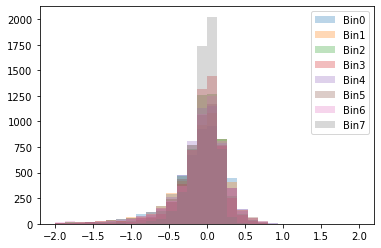

In [0]:
#distribution of residuals

for i in range(targ.shape[1]):
#  plt.figure()
  plt.hist((targ[:,i] - ypred[:,i])/(targ[:,i]+0.01), bins = 30, alpha = 0.3, range = [-2,2], label = 'Bin'+str(i))
plt.legend()

In [0]:
#

smapes = np.array([2 * smape(targ[i,:],ypred[i,:]) for i in range(targ.shape[0])])

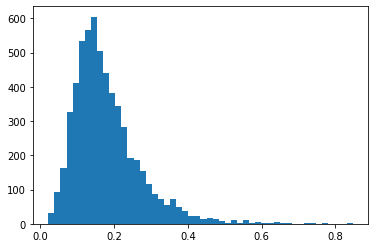

In [0]:
plt.hist(smapes, bins = 50);

In [0]:
from scipy import stats

In [0]:
stats.describe(smapes)

DescribeResult(nobs=5851, minmax=(0.021497441137042533, 0.8465597479796513), mean=0.17867202868650603, variance=0.008090173095306819, skewness=1.5633976670425058, kurtosis=4.20434101985343)

In [0]:
np.median(smapes)

0.16012715050675985

**Next step: train model on all data. Apply to other sims. Compare with EMDs and SOM-based distances. Exciting!**

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=40, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
mediansmapes = []

for spec in spectra.values():
  Xt = np.log10(spec[:,::2])
  SFHpred = bestmodel.predict(Xt) #predict on all other sims
  smapes = np.array([2 * smape(SFHs[i,:],SFHpred[i,:]) for i in range(SFHs.shape[0])])
  mediansmapes.append(np.median(smapes))

a = np.array(mediansmapes)

In [0]:
smapes = dict(zip(spectra.keys(),a))

In [0]:
smapes

{'bc03_dustA_spec': 0.24937033395796013,
 'bc03_dustB_spec': 0.23528570291639841,
 'bc03_dustC_spec': 0.22698198107701598,
 'bc03_int_spec': 0.6768479949305265,
 'bpass_dustA_spec': 0.23445830566093995,
 'bpass_dustB_spec': 0.22758600270595597,
 'bpass_dustC_spec': 0.22464032718642457,
 'bpass_int_spec': 0.6810513675788217,
 'bpass_sin_dustA_spec': 0.3236004371633811,
 'bpass_sin_dustB_spec': 0.3455423590850195,
 'bpass_sin_dustC_spec': 0.3614452757986425,
 'bpass_sin_int_spec': 0.6668520016397389,
 'fsps_dustA_spec': 0.15017376192736284,
 'fsps_dustB_spec': 0.05683577876967202,
 'fsps_dustC_spec': 0.14365922869303083,
 'fsps_int_spec': 0.5393774237322849,
 'fsps_neb_dustA_spec': 0.20594551912167294,
 'fsps_neb_dustB_spec': 0.20121278929696634,
 'fsps_neb_dustC_spec': 0.19966068074803198,
 'fsps_neb_int_spec': 0.5393774237322849}

In [0]:
smapesdict = {'bc03_dustA_spec': 0.24937033395796013,
 'bc03_dustB_spec': 0.23528570291639841,
 'bc03_dustC_spec': 0.22698198107701598,
 'bc03_int_spec': 0.6768479949305265,
 'bpass_dustA_spec': 0.23445830566093995,
 'bpass_dustB_spec': 0.22758600270595597,
 'bpass_dustC_spec': 0.22464032718642457,
 'bpass_int_spec': 0.6810513675788217,
 'bpass_sin_dustA_spec': 0.3236004371633811,
 'bpass_sin_dustB_spec': 0.3455423590850195,
 'bpass_sin_dustC_spec': 0.3614452757986425,
 'bpass_sin_int_spec': 0.6668520016397389,
 'fsps_dustA_spec': 0.15017376192736284,
 'fsps_dustB_spec': 0.05683577876967202,
 'fsps_dustC_spec': 0.14365922869303083,
 'fsps_int_spec': 0.5393774237322849,
 'fsps_neb_dustA_spec': 0.20594551912167294,
 'fsps_neb_dustB_spec': 0.20121278929696634,
 'fsps_neb_dustC_spec': 0.19966068074803198,
 'fsps_neb_int_spec': 0.5393774237322849}

In [0]:
filename = 'ref_fsps_dustB_spec_EMD.txt'

a = np.genfromtxt('My Drive/'+filename)

In [0]:
EMDs_ref_fsps_dustB = dict(zip(listofspec,a))  

In [18]:
EMDs_ref_fsps_dustB

{'bc03_dustA_spec': 0.01940738,
 'bc03_dustB_spec': 0.0209037,
 'bc03_dustC_spec': 0.02109747,
 'bc03_int_spec': 0.06160987,
 'bpass_dustA_spec': 0.09243587,
 'bpass_dustB_spec': 0.10889824,
 'bpass_dustC_spec': 0.0940256,
 'bpass_int_spec': 0.06765797,
 'bpass_sin_dustA_spec': 0.05079152,
 'bpass_sin_dustB_spec': 0.05310951,
 'bpass_sin_dustC_spec': 0.07318039,
 'bpass_sin_int_spec': 0.13020301,
 'fsps_dustA_spec': 0.00040344,
 'fsps_dustB_spec': 0.0,
 'fsps_dustC_spec': 0.00012656,
 'fsps_int_spec': 0.02521525,
 'fsps_neb_dustA_spec': 0.06972,
 'fsps_neb_dustB_spec': 0.06018871,
 'fsps_neb_dustC_spec': 0.08709233,
 'fsps_neb_int_spec': 0.04424306}

In [0]:
EMD_smapes = np.ones((len(listofspec),2))

for i, el in enumerate(smapesdict.keys()):
  (EMD_smapes[i,0],EMD_smapes[i,1]) = EMDs_ref_fsps_dustB[el],smapesdict[el] 

In [20]:
EMD_smapes

array([[1.94073800e-02, 2.49370334e-01],
       [2.09037000e-02, 2.35285703e-01],
       [2.10974700e-02, 2.26981981e-01],
       [6.16098700e-02, 6.76847995e-01],
       [9.24358700e-02, 2.34458306e-01],
       [1.08898240e-01, 2.27586003e-01],
       [9.40256000e-02, 2.24640327e-01],
       [6.76579700e-02, 6.81051368e-01],
       [5.07915200e-02, 3.23600437e-01],
       [5.31095100e-02, 3.45542359e-01],
       [7.31803900e-02, 3.61445276e-01],
       [1.30203010e-01, 6.66852002e-01],
       [4.03440000e-04, 1.50173762e-01],
       [0.00000000e+00, 5.68357788e-02],
       [1.26560000e-04, 1.43659229e-01],
       [2.52152500e-02, 5.39377424e-01],
       [6.97200000e-02, 2.05945519e-01],
       [6.01887100e-02, 2.01212789e-01],
       [8.70923300e-02, 1.99660681e-01],
       [4.42430600e-02, 5.39377424e-01]])

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


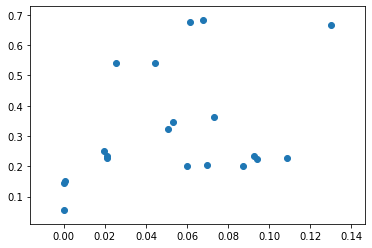

In [21]:
plt.scatter(EMD_smapes[:,0], EMD_smapes[:,1])

In [22]:
np.corrcoef(EMD_smapes[:,0], EMD_smapes[:,1])

array([[1.       , 0.3576188],
       [0.3576188, 1.       ]])

**TSNE summary: needs to be verified with another observable/algorithm/reference spectrum, but it doesn't look too promising. Maybe the mix of linear and nonlinear distances?**

**How about SOMs?**

In [0]:
listofspec

['bc03_int_spec',
 'bc03_dustA_spec',
 'bc03_dustB_spec',
 'bc03_dustC_spec',
 'fsps_int_spec',
 'fsps_dustA_spec',
 'fsps_dustB_spec',
 'fsps_dustC_spec',
 'fsps_neb_int_spec',
 'fsps_neb_dustA_spec',
 'fsps_neb_dustB_spec',
 'fsps_neb_dustC_spec',
 'bpass_int_spec',
 'bpass_dustA_spec',
 'bpass_dustB_spec',
 'bpass_dustC_spec',
 'bpass_sin_int_spec',
 'bpass_sin_dustA_spec',
 'bpass_sin_dustB_spec',
 'bpass_sin_dustC_spec']

In [0]:
#These are ordered like listofspec!

percentdistfromsom = np.array([[ 4.18020880e+00, -5.40621866e-01],
       [ 6.63422030e-01,  1.39418255e-01],
       [ 6.14433604e-01,  2.68806419e-01],
       [ 5.98212536e-01,  2.63791374e-01],
       [ 3.38151306e+00, -5.51654965e-01],
       [ 3.47571027e-02, -1.12337011e-01],
       [ 0.00000000e+00,  0.00000000e+00],
       [-2.94110905e-03,  8.62587763e-02],
       [ 3.38151306e+00, -5.51654965e-01],
       [ 4.33014276e+00, -4.81444333e-02],
       [ 2.92312849e+00,  1.00300903e-02],
       [ 2.12673818e+00,  8.22467402e-02],
       [ 5.24729636e+00, -5.48645938e-01],
       [ 2.07489638e+00,  3.19959880e-01],
       [ 2.09127213e+00,  4.29287864e-01],
       [ 2.11650391e+00,  4.68405216e-01],
       [ 4.78132311e+00, -1.73520562e-01],
       [ 3.24384671e+00,  2.50752257e-01],
       [ 3.30263296e+00,  1.95586760e-01],
       [ 3.34286396e+00,  1.07321966e-01]])

In [0]:
#percent difference in quantization error

diffquanterr = dict(zip(listofspec,percentdistfromsom[:,0]))  

In [0]:
diffquanterr, smapesdict

({'bc03_dustA_spec': 0.66342203,
  'bc03_dustB_spec': 0.614433604,
  'bc03_dustC_spec': 0.598212536,
  'bc03_int_spec': 4.1802088,
  'bpass_dustA_spec': 2.07489638,
  'bpass_dustB_spec': 2.09127213,
  'bpass_dustC_spec': 2.11650391,
  'bpass_int_spec': 5.24729636,
  'bpass_sin_dustA_spec': 3.24384671,
  'bpass_sin_dustB_spec': 3.30263296,
  'bpass_sin_dustC_spec': 3.34286396,
  'bpass_sin_int_spec': 4.78132311,
  'fsps_dustA_spec': 0.0347571027,
  'fsps_dustB_spec': 0.0,
  'fsps_dustC_spec': -0.00294110905,
  'fsps_int_spec': 3.38151306,
  'fsps_neb_dustA_spec': 4.33014276,
  'fsps_neb_dustB_spec': 2.92312849,
  'fsps_neb_dustC_spec': 2.12673818,
  'fsps_neb_int_spec': 3.38151306},
 {'bc03_dustA_spec': 0.24937033395796013,
  'bc03_dustB_spec': 0.23528570291639841,
  'bc03_dustC_spec': 0.22698198107701598,
  'bc03_int_spec': 0.6768479949305265,
  'bpass_dustA_spec': 0.23445830566093995,
  'bpass_dustB_spec': 0.22758600270595597,
  'bpass_dustC_spec': 0.22464032718642457,
  'bpass_int_sp

In [0]:
QE_smapes = np.ones((len(listofspec),2))

for i, el in enumerate(smapesdict.keys()):
  (QE_smapes[i,0],QE_smapes[i,1]) = diffquanterr[el],smapesdict[el] 

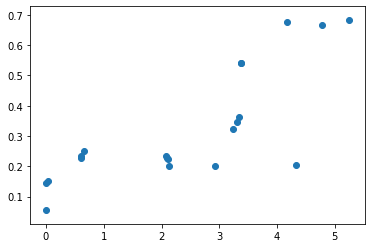

In [0]:
plt.scatter(QE_smapes[:,0], QE_smapes[:,1])

In [0]:
np.corrcoef(QE_smapes[:,0], QE_smapes[:,1])

array([[1.        , 0.78404634],
       [0.78404634, 1.        ]])

**SOM Summary: appears to be more promising, needs same verifications as TSNE**

**Let's see what happens for ref spectrum = bc03, dust A**



In [0]:
ref_spec = spectra['bc03_dustA_spec']

Let's log those spectra

In [0]:
X = np.log10(ref_spec)

In [10]:
X.shape

(6473, 4601)

In [0]:
np.random.seed(10)
sel = np.random.choice(X.shape[0], 650) #make it smaller; technically should re-run optimization with seed fixed

In [0]:
model = RandomForestRegressor()

In [0]:
cv = KFold(shuffle = True, n_splits=3)

In [0]:
allindexes = np.arange(X.shape[0])

ind = allindexes[~np.isin(allindexes,sel)]

feat = X[ind,::2]

targ = SFHs[ind]

In [0]:
bestmodel = RandomForestRegressor(max_depth = 40, max_features = 0.5)

In [0]:
bestmodel.fit(X[:,::2], SFHs)

In [0]:
mediansmapes = []

for spec in spectra.values():
  Xt = np.log10(spec[:,::2])
  SFHpred = bestmodel.predict(Xt) #predict on all other sims
  smapes = np.array([2 * smape(SFHs[i,:],SFHpred[i,:]) for i in range(SFHs.shape[0])])
  mediansmapes.append(np.median(smapes))

a = np.array(mediansmapes)

In [0]:
smapes = dict(zip(spectra.keys(),a))

In [21]:
smapes

{'bc03_dustA_spec': 0.05805241119841847,
 'bc03_dustB_spec': 0.14940084848445856,
 'bc03_dustC_spec': 0.15385214161981647,
 'bc03_int_spec': 0.5175300071929866,
 'bpass_dustA_spec': 0.28565268760805934,
 'bpass_dustB_spec': 0.2694501060600998,
 'bpass_dustC_spec': 0.25818414518346955,
 'bpass_int_spec': 0.7061046186606078,
 'bpass_sin_dustA_spec': 0.29659311424578083,
 'bpass_sin_dustB_spec': 0.3015134095866088,
 'bpass_sin_dustC_spec': 0.3064039240052663,
 'bpass_sin_int_spec': 0.6879383878397539,
 'fsps_dustA_spec': 0.1880940638794513,
 'fsps_dustB_spec': 0.18721928615332847,
 'fsps_dustC_spec': 0.18834118107332087,
 'fsps_int_spec': 0.5271486599631381,
 'fsps_neb_dustA_spec': 0.19894540409499165,
 'fsps_neb_dustB_spec': 0.20186479145872868,
 'fsps_neb_dustC_spec': 0.2053338505543621,
 'fsps_neb_int_spec': 0.5271486599631381}

In [0]:
filename = 'ref_bc03_dustA_spec_EMD.txt'

b = np.genfromtxt('My Drive/'+filename)

In [0]:
EMDs_ref_bc03_dustA = dict(zip(listofspec,b))  

In [24]:
EMDs_ref_bc03_dustA

{'bc03_dustA_spec': 0.019407382,
 'bc03_dustB_spec': 0.0209037049,
 'bc03_dustC_spec': 0.0210974658,
 'bc03_int_spec': 0.0616098744,
 'bpass_dustA_spec': 0.0924358731,
 'bpass_dustB_spec': 0.108898242,
 'bpass_dustC_spec': 0.0940255978,
 'bpass_int_spec': 0.067657967,
 'bpass_sin_dustA_spec': 0.0507915163,
 'bpass_sin_dustB_spec': 0.0531095064,
 'bpass_sin_dustC_spec': 0.0731803904,
 'bpass_sin_int_spec': 0.1302030082,
 'fsps_dustA_spec': 0.0004034421,
 'fsps_dustB_spec': 0.0,
 'fsps_dustC_spec': 0.0001265624,
 'fsps_int_spec': 0.0252152481,
 'fsps_neb_dustA_spec': 0.0697199964,
 'fsps_neb_dustB_spec': 0.0601887055,
 'fsps_neb_dustC_spec': 0.0870923324,
 'fsps_neb_int_spec': 0.0442430615}

In [0]:
EMD_smapes = np.ones((len(listofspec),2))

for i, el in enumerate(smapes.keys()):
  (EMD_smapes[i,0],EMD_smapes[i,1]) = EMDs_ref_bc03_dustA[el],smapes[el] 

In [27]:
EMD_smapes

array([[6.16098744e-02, 5.17530007e-01],
       [1.94073820e-02, 5.80524112e-02],
       [2.09037049e-02, 1.49400848e-01],
       [2.10974658e-02, 1.53852142e-01],
       [2.52152481e-02, 5.27148660e-01],
       [4.03442100e-04, 1.88094064e-01],
       [0.00000000e+00, 1.87219286e-01],
       [1.26562400e-04, 1.88341181e-01],
       [4.42430615e-02, 5.27148660e-01],
       [6.97199964e-02, 1.98945404e-01],
       [6.01887055e-02, 2.01864791e-01],
       [8.70923324e-02, 2.05333851e-01],
       [6.76579670e-02, 7.06104619e-01],
       [9.24358731e-02, 2.85652688e-01],
       [1.08898242e-01, 2.69450106e-01],
       [9.40255978e-02, 2.58184145e-01],
       [1.30203008e-01, 6.87938388e-01],
       [5.07915163e-02, 2.96593114e-01],
       [5.31095064e-02, 3.01513410e-01],
       [7.31803904e-02, 3.06403924e-01]])

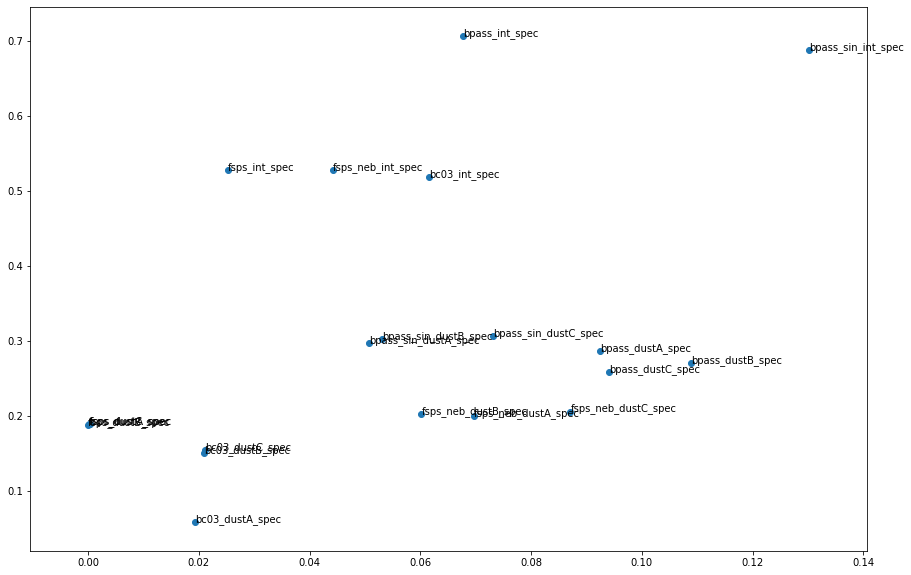

In [37]:
plt.figure(figsize=(15,10))

plt.scatter(EMD_smapes[:,0], EMD_smapes[:,1])#], label = el)

for i, el in enumerate(smapes.keys()):
    plt.annotate(el, (EMD_smapes[i,0], EMD_smapes[i,1]))
  

In [29]:
np.corrcoef(EMD_smapes[:,0], EMD_smapes[:,1])

array([[1.       , 0.4219836],
       [0.4219836, 1.       ]])

In [0]:
#Do not run: cv with r2 score

#Results

#{'fit_time': array([53.27171755, 52.12764168, 53.28606129, 53.26166272]),
# 'score_time': array([0.01601958, 0.0146246 , 0.01494336, 0.01519322]),
# 'test_score': array([0.81165198, 0.87030236, 0.86739246, 0.88866265]),
# 'train_score': array([0.98043601, 0.97968621, 0.98108432, 0.97960353])}

cv = KFold(shuffle = True, n_splits=4)

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, return_train_score=True);

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

In [0]:
cv_results

{'fit_time': array([53.27171755, 52.12764168, 53.28606129, 53.26166272]),
 'score_time': array([0.01601958, 0.0146246 , 0.01494336, 0.01519322]),
 'test_score': array([0.81165198, 0.87030236, 0.86739246, 0.88866265]),
 'train_score': array([0.98043601, 0.97968621, 0.98108432, 0.97960353])}

In [0]:
#Do not run, CV with neg med abs err

#{'fit_time': array([54.1445663 , 52.86333227, 53.88323212, 54.79486084]),
# 'score_time': array([0.01488876, 0.01699281, 0.01373649, 0.01461649]),
# 'test_score': array([-0.40613118, -0.46373731, -0.40043115, -0.37756717]),
# 'train_score': array([-0.14555735, -0.14599829, -0.15410287, -0.1604189 ])}

cv_results = cross_validate(model, X[sel,::2], targets,  cv = cv, scoring = 'neg_median_absolute_error', return_train_score=True);

In [0]:
cv_results

{'fit_time': array([54.1445663 , 52.86333227, 53.88323212, 54.79486084]),
 'score_time': array([0.01488876, 0.01699281, 0.01373649, 0.01461649]),
 'test_score': array([-0.40613118, -0.46373731, -0.40043115, -0.37756717]),
 'train_score': array([-0.14555735, -0.14599829, -0.15410287, -0.1604189 ])}

In [0]:
parameters = {'max_depth':[20,40], \
              'max_features': [0.25,0.5,1.0], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = smape_scorer, return_train_score = True, \
    verbose = 2, n_jobs = 4)
model.fit(X[sel,::2], targets)
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
#print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [0]:
parameters = {'max_depth':[8,12,20], \
              'max_features': ['auto','sqrt'], 'n_estimators':[100,200]}
nmodels = np.product([len(el) for el in parameters.values()])

model = GridSearchCV(RandomForestRegressor(), parameters, cv = cv, \
                     scoring = 'neg_median_absolute_error', return_train_score = True, \
    verbose = 2, n_jobs = 4)
start = time.time()
model.fit(X[sel,::2], targets)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model.best_score_), model.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels*4)))

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done  48 out of  48 | elapsed: 25.9min finished


Best params, best score: -0.3992 {'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}
Time per model (s): 35.4968


In [0]:
model.cv_results_

{'mean_fit_time': array([142.08366597, 281.02833021,   3.62773597,   7.20128304,
        175.92155129, 354.93943012,   4.40083194,   8.71038419,
        185.85670829, 371.20518613,   4.79526126,   8.64055562]),
 'mean_score_time': array([0.03765577, 0.06617844, 0.04712707, 0.07398534, 0.0460602 ,
        0.08255142, 0.04830873, 0.08664465, 0.04365295, 0.09512132,
        0.05063039, 0.0543642 ]),
 'mean_test_score': array([-0.44103841, -0.44494769, -0.48930196, -0.48785785, -0.40170052,
        -0.40611576, -0.44119677, -0.44180372, -0.4014455 , -0.39918231,
        -0.44515741, -0.43259462]),
 'mean_train_score': array([-0.31310871, -0.31072779, -0.35199807, -0.35286472, -0.17899306,
        -0.18147997, -0.20830142, -0.20607399, -0.14763381, -0.14861138,
        -0.16305295, -0.1631004 ]),
 'param_max_depth': masked_array(data=[8, 8, 8, 8, 12, 12, 12, 12, 20, 20, 20, 20],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fal

In [0]:
a = pd.DataFrame(model.cv_results_)
a[['mean_train_score','mean_test_score','params',mean_fit_time]].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

NameError: ignored

In [0]:
parameters2 = {'max_depth':[20,30,40], \
              'max_features': ['auto'], 'n_estimators':[200,500]}

nmodels2 = np.product([len(el) for el in parameters2.values()])

model2 = GridSearchCV(RandomForestRegressor(), parameters2, cv = cv, \
                     scoring = 'neg_median_absolute_error', return_train_score = True, \
    verbose = 2, n_jobs = 4)
start = time.time()
model2.fit(X[sel,::2], targets)
stop = time.time()
print('Best params, best score:', "{:.4f}".format(model2.best_score_), model2.best_params_),
print('Time per model (s):', "{:.4f}".format((stop-start)/float(nmodels2*4)))


Fitting 4 folds for each of 6 candidates, totalling 24 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 out of  24 | elapsed: 64.9min finished


Best params, best score: -0.3959 {'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}
Time per model (s): 168.6162


In [0]:
b = pd.DataFrame(model2.cv_results_)
b[['mean_train_score','mean_test_score','params','mean_fit_time']].sort_values('mean_test_score', ascending = False)#, sortedby = 'mean_test_score')

,mean_train_score,mean_test_score,params,mean_fit_time
2,-0.146802,-0.395946,"{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 200}",369.994167
4,-0.146782,-0.400436,"{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 200}",372.839408
3,-0.146567,-0.400541,"{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 500}",926.055208
1,-0.147896,-0.401356,"{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 500}",923.513032
0,-0.148202,-0.401552,"{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 200}",371.707079
5,-0.147294,-0.402877,"{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 500}",919.583136


In [0]:
smape_scorer = make_scorer(multioutputsmape, greater_is_better = False)

NameError: ignored

In [0]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [0]:
#This helps visualize the training vs the test. Will help us visualize and see what would happen if we use more data or if 
#the data has plateaued. 

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5), scoring = 'accuracy'):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = scoring, verbose = 2)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test score from cross-validation")

    plt.legend(loc="best")
    return plt

In [0]:
a.tr